# Importing necessary things

In [1]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import re
from datetime import datetime

import pickle

==================================================================================================================

# Unpickling our data and taking a look

In [2]:
df = pd.read_pickle('reviewfeatures.pkl')
df

,title,installs,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,genreId,released,contentRating,appId
0,Among Us,"100,000,000+",100000000,4.456063,2668720.0,1362398.0,"[208157, 50032, 107074, 254737, 2048720]",0.00,True,True,70M,Action,GAME_ACTION,"Jun 15, 2018",Everyone 10+,com.innersloth.spacemafia
1,Scribble Rider,"50,000,000+",50000000,3.762067,233833.0,97101.0,"[47154, 12830, 18851, 24661, 130337]",0.00,True,True,127M,Action,GAME_ACTION,"Jul 23, 2020",Everyone,com.tapped.drawrider
2,Call of Duty®: Mobile,"100,000,000+",100000000,4.468448,10830558.0,4982589.0,"[808396, 208675, 410554, 1076290, 8326643]",0.00,True,True,94M,Action,GAME_ACTION,"Sep 30, 2019",Mature 17+,com.activision.callofduty.shooter
3,slither.io,"100,000,000+",100000000,4.060273,6289940.0,2612866.0,"[842869, 250387, 498673, 790843, 3907168]",0.00,True,True,Varies with device,Action,GAME_ACTION,"Mar 25, 2016",Everyone,air.com.hypah.io.slither
4,Hitmasters,"50,000,000+",50000000,4.099427,285765.0,100795.0,"[40013, 10334, 17576, 31144, 186698]",0.00,True,True,85M,Action,GAME_ACTION,"Mar 19, 2020",Teen,com.playgendary.hitmasters
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5117,Cryptic Crossword,"10,000+",10000,4.711340,2068.0,862.0,"[21, 10, 42, 394, 1601]",3.99,False,False,Varies with device,Word,GAME_WORD,"Nov 3, 2010",Everyone,com.teazel.crossword.cryptic.full
5118,Acrostics Crossword Puzzles,"10,000+",10000,4.350000,372.0,180.0,"[18, 11, 33, 67, 243]",3.99,False,True,15M,Word,GAME_WORD,"Mar 18, 2013",Everyone,agamz.acrostics
5119,Jumbline 2,"10,000+",10000,4.588785,1289.0,628.0,"[36, 0, 84, 217, 952]",2.99,False,False,35M,Word,GAME_WORD,"Nov 1, 2011",Everyone,com.brainium.jumbline2
5120,Word Breaker Full,"10,000+",10000,4.180000,1109.0,587.0,"[55, 33, 166, 255, 600]",2.99,False,False,14M,Word,GAME_WORD,"Feb 24, 2011",Everyone,com.firecrackersw.wordbreakerfull


In [3]:
df.columns

Index(['title', 'installs', 'minInstalls', 'score', 'ratings', 'reviews',
       'histogram', 'price', 'free', 'offersIAP', 'size', 'genre', 'genreId',
       'released', 'contentRating', 'appId'],
      dtype='object')

In [4]:
df.dtypes

title             object
installs          object
minInstalls        int64
score            float64
ratings          float64
reviews          float64
histogram         object
price            float64
free                bool
offersIAP           bool
size              object
genre             object
genreId           object
released          object
contentRating     object
appId             object
dtype: object

In [5]:
# Will drop games with no ratings

df.isna().sum()

title             0
installs          0
minInstalls       0
score             6
ratings          76
reviews           6
histogram         0
price             0
free              0
offersIAP         0
size              0
genre             0
genreId           0
released         16
contentRating     0
appId             0
dtype: int64

In [6]:
# 91 rows were removed.

df.dropna(inplace=True)

In [7]:
# Can probably drop this column as it's the same as minInstalls but in an object format.

df['installs'].value_counts()

1,000,000+        894
10,000,000+       829
100,000+          663
10,000+           643
5,000,000+        440
50,000+           301
500,000+          299
1,000+            278
5,000+            210
50,000,000+       198
100,000,000+      133
100+               64
500+               61
500,000,000+        9
50+                 9
10+                 3
1,000,000,000+      2
Name: installs, dtype: int64

In [8]:
# Possibly reduce this columns to fewer categories.

df['minInstalls'].value_counts()

1000000       894
10000000      829
100000        663
10000         643
5000000       440
50000         301
500000        299
1000          278
5000          210
50000000      198
100000000     133
100            64
500            61
50              9
500000000       9
10              3
1000000000      2
Name: minInstalls, dtype: int64

In [9]:
# We are only looking at the apps listed in the Top Free and Top Paid categories, so it makes sense the mean is high.

df['score'].describe()

count    5036.000000
mean        4.216481
std         0.412596
min         1.000000
25%         4.027189
50%         4.277893
75%         4.497392
max         5.000000
Name: score, dtype: float64

In [10]:
df['ratings'].describe()

count    5.036000e+03
mean     2.777024e+05
std      1.791172e+06
min      5.000000e+00
25%      1.154500e+03
50%      1.029500e+04
75%      7.836150e+04
max      6.507942e+07
Name: ratings, dtype: float64

In [11]:
df['reviews'].describe()

count    5.036000e+03
mean     1.092222e+05
std      8.309096e+05
min      1.000000e+00
25%      4.780000e+02
50%      4.046000e+03
75%      3.098350e+04
max      3.942706e+07
Name: reviews, dtype: float64

In [12]:
# Will reduce this columns to fewer categories.

df['price'].value_counts()

0.00     3329
2.99      323
0.99      293
4.99      248
1.99      240
3.99      156
6.99       54
9.99       45
2.49       42
5.99       42
3.49       42
1.49       38
5.49       35
7.99       27
4.49       19
8.99       12
14.99      11
15.99       8
1.00        6
19.99       6
7.49        5
1.96        4
13.99       4
6.49        4
11.99       4
17.99       3
24.99       3
12.99       2
5.00        2
2.69        2
29.99       2
32.99       1
3.75        1
1.39        1
2.00        1
1.50        1
2.77        1
1.02        1
22.99       1
1.94        1
4.89        1
9.49        1
1.05        1
1.59        1
20.99       1
5.60        1
4.40        1
1.20        1
3.63        1
2.19        1
4.29        1
1.90        1
8.49        1
1.95        1
3.89        1
18.99       1
Name: price, dtype: int64

In [13]:
# A decent number of these games are free games

df['free'].value_counts()

True     3329
False    1707
Name: free, dtype: int64

In [14]:
# Numbers are similar to whether games are free to play or not.
# Differences at a glance suggests a fair number of free games with no IAPs and paid games that still have IAPs

df['offersIAP'].value_counts()

True     3120
False    1916
Name: offersIAP, dtype: int64

In [15]:
df['size'].value_counts()

Varies with device    630
37M                    62
49M                    60
28M                    58
47M                    57
                     ... 
956k                    1
174M                    1
2.5M                    1
9.8M                    1
353M                    1
Name: size, Length: 279, dtype: int64

In [16]:
# Fair spread of games in each category.

df['genre'].value_counts()

Adventure       395
Role Playing    394
Simulation      394
Strategy        357
Puzzle          351
Educational     339
Action          333
Board           304
Arcade          299
Casual          289
Card            247
Sports          245
Racing          240
Word            217
Music           216
Casino          209
Trivia          207
Name: genre, dtype: int64

In [17]:
# Can remove this column as it's the same thing as genre.

df['genreId'].value_counts()

GAME_ADVENTURE       395
GAME_ROLE_PLAYING    394
GAME_SIMULATION      394
GAME_STRATEGY        357
GAME_PUZZLE          351
GAME_EDUCATIONAL     339
GAME_ACTION          333
GAME_BOARD           304
GAME_ARCADE          299
GAME_CASUAL          289
GAME_CARD            247
GAME_SPORTS          245
GAME_RACING          240
GAME_WORD            217
GAME_MUSIC           216
GAME_CASINO          209
GAME_TRIVIA          207
Name: genreId, dtype: int64

In [18]:
# Need to change this to a useable column.

df['released'].value_counts()

Jul 28, 2020    14
Jul 23, 2020    13
Apr 24, 2020    13
Aug 19, 2020    12
Aug 26, 2020    12
                ..
Jan 6, 2019      1
Jun 17, 2013     1
Nov 7, 2012      1
Oct 20, 2015     1
Nov 30, 2012     1
Name: released, Length: 2146, dtype: int64

In [19]:
# Most top apps are either for Everyone or Teen. Makes sense to appeal to wider audiences.

df['contentRating'].value_counts()

Everyone           3017
Teen               1293
Everyone 10+        562
Mature 17+          158
Adults only 18+       6
Name: contentRating, dtype: int64

==================================================================================================================

# Cleaning

In [20]:
df.drop(columns=['installs', 'genreId'], inplace=True)
df

,title,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,released,contentRating,appId
0,Among Us,100000000,4.456063,2668720.0,1362398.0,"[208157, 50032, 107074, 254737, 2048720]",0.00,True,True,70M,Action,"Jun 15, 2018",Everyone 10+,com.innersloth.spacemafia
1,Scribble Rider,50000000,3.762067,233833.0,97101.0,"[47154, 12830, 18851, 24661, 130337]",0.00,True,True,127M,Action,"Jul 23, 2020",Everyone,com.tapped.drawrider
2,Call of Duty®: Mobile,100000000,4.468448,10830558.0,4982589.0,"[808396, 208675, 410554, 1076290, 8326643]",0.00,True,True,94M,Action,"Sep 30, 2019",Mature 17+,com.activision.callofduty.shooter
3,slither.io,100000000,4.060273,6289940.0,2612866.0,"[842869, 250387, 498673, 790843, 3907168]",0.00,True,True,Varies with device,Action,"Mar 25, 2016",Everyone,air.com.hypah.io.slither
4,Hitmasters,50000000,4.099427,285765.0,100795.0,"[40013, 10334, 17576, 31144, 186698]",0.00,True,True,85M,Action,"Mar 19, 2020",Teen,com.playgendary.hitmasters
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5116,Word Search Daily PRO (900+ Levels),1000,4.425532,47.0,19.0,"[2, 0, 4, 11, 30]",1.99,False,False,9.9M,Word,"Aug 13, 2018",Everyone,air.com.littlebigplay.games.wordsearchdailypro
5117,Cryptic Crossword,10000,4.711340,2068.0,862.0,"[21, 10, 42, 394, 1601]",3.99,False,False,Varies with device,Word,"Nov 3, 2010",Everyone,com.teazel.crossword.cryptic.full
5118,Acrostics Crossword Puzzles,10000,4.350000,372.0,180.0,"[18, 11, 33, 67, 243]",3.99,False,True,15M,Word,"Mar 18, 2013",Everyone,agamz.acrostics
5119,Jumbline 2,10000,4.588785,1289.0,628.0,"[36, 0, 84, 217, 952]",2.99,False,False,35M,Word,"Nov 1, 2011",Everyone,com.brainium.jumbline2


In [21]:
df['releasedate'] = df['released'].apply(pd.to_datetime)
df.drop(columns=['released'], inplace=True)
df

,title,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,contentRating,appId,releasedate
0,Among Us,100000000,4.456063,2668720.0,1362398.0,"[208157, 50032, 107074, 254737, 2048720]",0.00,True,True,70M,Action,Everyone 10+,com.innersloth.spacemafia,2018-06-15
1,Scribble Rider,50000000,3.762067,233833.0,97101.0,"[47154, 12830, 18851, 24661, 130337]",0.00,True,True,127M,Action,Everyone,com.tapped.drawrider,2020-07-23
2,Call of Duty®: Mobile,100000000,4.468448,10830558.0,4982589.0,"[808396, 208675, 410554, 1076290, 8326643]",0.00,True,True,94M,Action,Mature 17+,com.activision.callofduty.shooter,2019-09-30
3,slither.io,100000000,4.060273,6289940.0,2612866.0,"[842869, 250387, 498673, 790843, 3907168]",0.00,True,True,Varies with device,Action,Everyone,air.com.hypah.io.slither,2016-03-25
4,Hitmasters,50000000,4.099427,285765.0,100795.0,"[40013, 10334, 17576, 31144, 186698]",0.00,True,True,85M,Action,Teen,com.playgendary.hitmasters,2020-03-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5116,Word Search Daily PRO (900+ Levels),1000,4.425532,47.0,19.0,"[2, 0, 4, 11, 30]",1.99,False,False,9.9M,Word,Everyone,air.com.littlebigplay.games.wordsearchdailypro,2018-08-13
5117,Cryptic Crossword,10000,4.711340,2068.0,862.0,"[21, 10, 42, 394, 1601]",3.99,False,False,Varies with device,Word,Everyone,com.teazel.crossword.cryptic.full,2010-11-03
5118,Acrostics Crossword Puzzles,10000,4.350000,372.0,180.0,"[18, 11, 33, 67, 243]",3.99,False,True,15M,Word,Everyone,agamz.acrostics,2013-03-18
5119,Jumbline 2,10000,4.588785,1289.0,628.0,"[36, 0, 84, 217, 952]",2.99,False,False,35M,Word,Everyone,com.brainium.jumbline2,2011-11-01


In [22]:
# minInstalls a little difficult to work with due to very distant categories
# Title is not useful as a feature
# Score is what we're trying to predict so we will remove it
# Histogram is difficult to work with in this context
# Size is difficult to work with, as there are a lot of varying sizes, and changes with updates quite frequently.
# Price is a little difficult to work with as there are sales/promotions sometimes

df.drop(columns=['title', 'score', 'histogram', 'size', 'price', 'minInstalls'], inplace=True)
df

,ratings,reviews,free,offersIAP,genre,contentRating,appId,releasedate
0,2668720.0,1362398.0,True,True,Action,Everyone 10+,com.innersloth.spacemafia,2018-06-15
1,233833.0,97101.0,True,True,Action,Everyone,com.tapped.drawrider,2020-07-23
2,10830558.0,4982589.0,True,True,Action,Mature 17+,com.activision.callofduty.shooter,2019-09-30
3,6289940.0,2612866.0,True,True,Action,Everyone,air.com.hypah.io.slither,2016-03-25
4,285765.0,100795.0,True,True,Action,Teen,com.playgendary.hitmasters,2020-03-19
...,...,...,...,...,...,...,...,...
5116,47.0,19.0,False,False,Word,Everyone,air.com.littlebigplay.games.wordsearchdailypro,2018-08-13
5117,2068.0,862.0,False,False,Word,Everyone,com.teazel.crossword.cryptic.full,2010-11-03
5118,372.0,180.0,False,True,Word,Everyone,agamz.acrostics,2013-03-18
5119,1289.0,628.0,False,False,Word,Everyone,com.brainium.jumbline2,2011-11-01


==================================================================================================================

# EDA

In [24]:
import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [25]:
bigreviewlist = decompress_pickle('compressedbiglistreview.pbz2')
len(bigreviewlist)

1041127

In [26]:
dfreview = pd.DataFrame(bigreviewlist)
dfreview

,content,score,appId
0,"Great game! First, the bad. There are plenty o...",4,com.innersloth.spacemafia
1,It's a really amazing start for a game but the...,4,com.innersloth.spacemafia
2,A wonderful game to test how strong your bond ...,5,com.innersloth.spacemafia
3,"It's an extremely fun game, it's only setback ...",4,com.innersloth.spacemafia
4,"It's a really fun game, especially if you're t...",5,com.innersloth.spacemafia
...,...,...,...
1041122,Love this app. Very helpful !,5,com.firecrackersw.wordbreakerfull
1041123,Excellent app.,5,com.firecrackersw.wordbreakerfull
1041124,Still doesn't find the highest scoring words 9...,2,com.firecrackersw.wordbreakerfull
1041125,Which is the best dictionary for English's uk ...,5,com.firecrackersw.wordbreakerfull


In [27]:
dfreview.isna().sum()

content    209
score        0
appId        0
dtype: int64

In [28]:
dfreview.dropna(inplace=True)
dfreview

,content,score,appId
0,"Great game! First, the bad. There are plenty o...",4,com.innersloth.spacemafia
1,It's a really amazing start for a game but the...,4,com.innersloth.spacemafia
2,A wonderful game to test how strong your bond ...,5,com.innersloth.spacemafia
3,"It's an extremely fun game, it's only setback ...",4,com.innersloth.spacemafia
4,"It's a really fun game, especially if you're t...",5,com.innersloth.spacemafia
...,...,...,...
1041122,Love this app. Very helpful !,5,com.firecrackersw.wordbreakerfull
1041123,Excellent app.,5,com.firecrackersw.wordbreakerfull
1041124,Still doesn't find the highest scoring words 9...,2,com.firecrackersw.wordbreakerfull
1041125,Which is the best dictionary for English's uk ...,5,com.firecrackersw.wordbreakerfull


In [29]:
dfreview['score'].value_counts()

5    514234
1    188103
4    159399
3    104857
2     74308
0        17
Name: score, dtype: int64

In [30]:
dfreview = dfreview[dfreview['score'] != 0]

In [31]:
count1 = len(dfreview[dfreview['score'] == 1])
count2 = len(dfreview[dfreview['score'] == 2])
count3 = len(dfreview[dfreview['score'] == 3])
count4 = len(dfreview[dfreview['score'] == 4])
count5 = len(dfreview[dfreview['score'] == 5])

total = count1 + count2 + count3 + count4 + count5

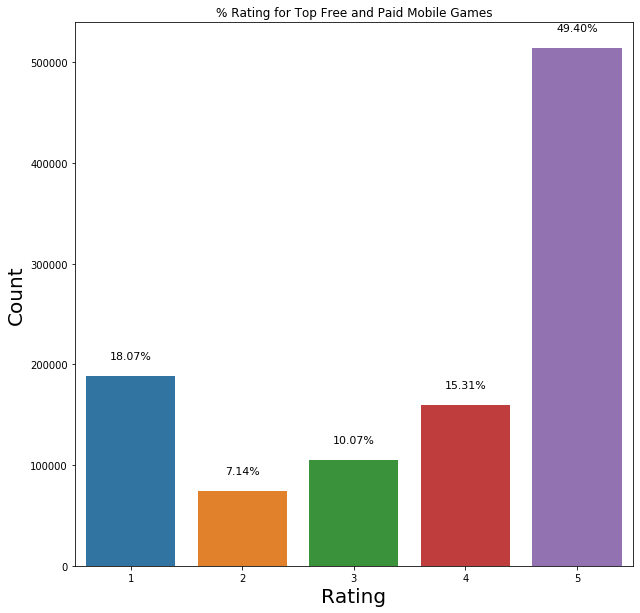

In [32]:
plt.figure(figsize=(10,10))

xaxis = ['1', '2', '3', '4', '5']
yaxis = [count1, count2, count3, count4, count5]
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Top Free and Paid Mobile Games')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/total)+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [33]:
# Separating reviews into their scores.

rating1 = dfreview.loc[dfreview['score'] == 1]
rating2 = dfreview.loc[dfreview['score'] == 2]
rating3 = dfreview.loc[dfreview['score'] == 3]
rating4 = dfreview.loc[dfreview['score'] == 4]
rating5 = dfreview.loc[dfreview['score'] == 5]

In [34]:
rating1.head(2)

,content,score,appId
81,This is a rubbish game that would not let me j...,1,com.innersloth.spacemafia
146,Would be a good game but its filled with group...,1,com.innersloth.spacemafia


In [35]:
rating2.head(2)

,content,score,appId
35,I really enjoy the game but it has some proble...,2,com.innersloth.spacemafia
40,"SO. MANY. BUGS. The game is great, enjoyable a...",2,com.innersloth.spacemafia


In [36]:
rating3.head(2)

,content,score,appId
15,After playing this game for a while. I see a f...,3,com.innersloth.spacemafia
19,"The game is absolutely wonderful, on pc. Playi...",3,com.innersloth.spacemafia


In [37]:
rating4.head(2)

,content,score,appId
0,"Great game! First, the bad. There are plenty o...",4,com.innersloth.spacemafia
1,It's a really amazing start for a game but the...,4,com.innersloth.spacemafia


In [38]:
rating5.head(2)

,content,score,appId
2,A wonderful game to test how strong your bond ...,5,com.innersloth.spacemafia
4,"It's a really fun game, especially if you're t...",5,com.innersloth.spacemafia


### Tokenizing

In [39]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [40]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed    

In [41]:
# 

starttime = datetime.now()

rating1['wordlist'] = rating1['content'].apply(lambda x: process_reviews(x))
rating2['wordlist'] = rating2['content'].apply(lambda x: process_reviews(x))
rating3['wordlist'] = rating3['content'].apply(lambda x: process_reviews(x))
rating4['wordlist'] = rating4['content'].apply(lambda x: process_reviews(x))
rating5['wordlist'] = rating5['content'].apply(lambda x: process_reviews(x))

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:07:24.972278


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Lemmatizer

In [42]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [43]:
starttime = datetime.now()

rating1['wordlistlem'] = rating1['wordlist'].apply(lemmatize_text)
rating2['wordlistlem'] = rating2['wordlist'].apply(lemmatize_text)
rating3['wordlistlem'] = rating3['wordlist'].apply(lemmatize_text)
rating4['wordlistlem'] = rating4['wordlist'].apply(lemmatize_text)
rating5['wordlistlem'] = rating5['wordlist'].apply(lemmatize_text)

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:01:59.319822


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Saving Dataframes

In [44]:
# Saving tokens into a sub-folder in for tidiness.

from pathlib import Path

root = Path('.')

my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

In [45]:
compressed_pickle(my_path1, rating1)
compressed_pickle(my_path2, rating2)
compressed_pickle(my_path3, rating3)
compressed_pickle(my_path4, rating4)
compressed_pickle(my_path5, rating5)

In [46]:
# Retrieve our pickled dataframes

rating1 = decompress_pickle(my_path1)
rating2 = decompress_pickle(my_path2)
rating3 = decompress_pickle(my_path3)
rating4 = decompress_pickle(my_path4)
rating5 = decompress_pickle(my_path5)

## Word Frequency in all reviews

In [47]:
rating1['wordlistlem'].head()

81     [rubbish, game, would, let, join, host, game, ...
146    [would, good, game, filled, group, people, pri...
197    [want, play, game, friend, recommended, suppos...
215    [good, game, found, modders, mod, menu, game, ...
253    [stupid.., stupid.., stupid, ad, ad, seriously...
Name: wordlistlem, dtype: object

In [48]:
starttime = datetime.now()

processedreviewrating1 = [item for elem in rating1['wordlistlem'] for item in elem]
processedreviewrating2 = [item for elem in rating2['wordlistlem'] for item in elem]
processedreviewrating3 = [item for elem in rating3['wordlistlem'] for item in elem]
processedreviewrating4 = [item for elem in rating4['wordlistlem'] for item in elem]
processedreviewrating5 = [item for elem in rating5['wordlistlem'] for item in elem]

print(datetime.now() - starttime)
print('------------')
print(len(processedreviewrating1))
print(len(processedreviewrating2))
print(len(processedreviewrating3))
print(len(processedreviewrating4))
print(len(processedreviewrating5))

0:00:01.046164
------------
3501669
1598683
2119339
2842957
6932989


In [49]:
# 17.1 million words total.

totalprocessedreviews = processedreviewrating1 + processedreviewrating2 + processedreviewrating3 + processedreviewrating4 + processedreviewrating5
len(totalprocessedreviews)

16995637

In [50]:
review_freqdist = FreqDist(totalprocessedreviews)
review_freqdist.most_common(20)

[('game', 1105600),
 ('like', 233824),
 ('play', 216554),
 ('good', 196449),
 ('fun', 187192),
 ('love', 186848),
 ('get', 179136),
 ('ad', 171374),
 ('time', 153533),
 ('great', 146498),
 ('really', 136139),
 ('one', 119789),
 ('app', 109534),
 ('would', 107370),
 ('make', 106168),
 ('level', 102526),
 ('playing', 87480),
 ('much', 82311),
 ('star', 77927),
 ('even', 75129)]

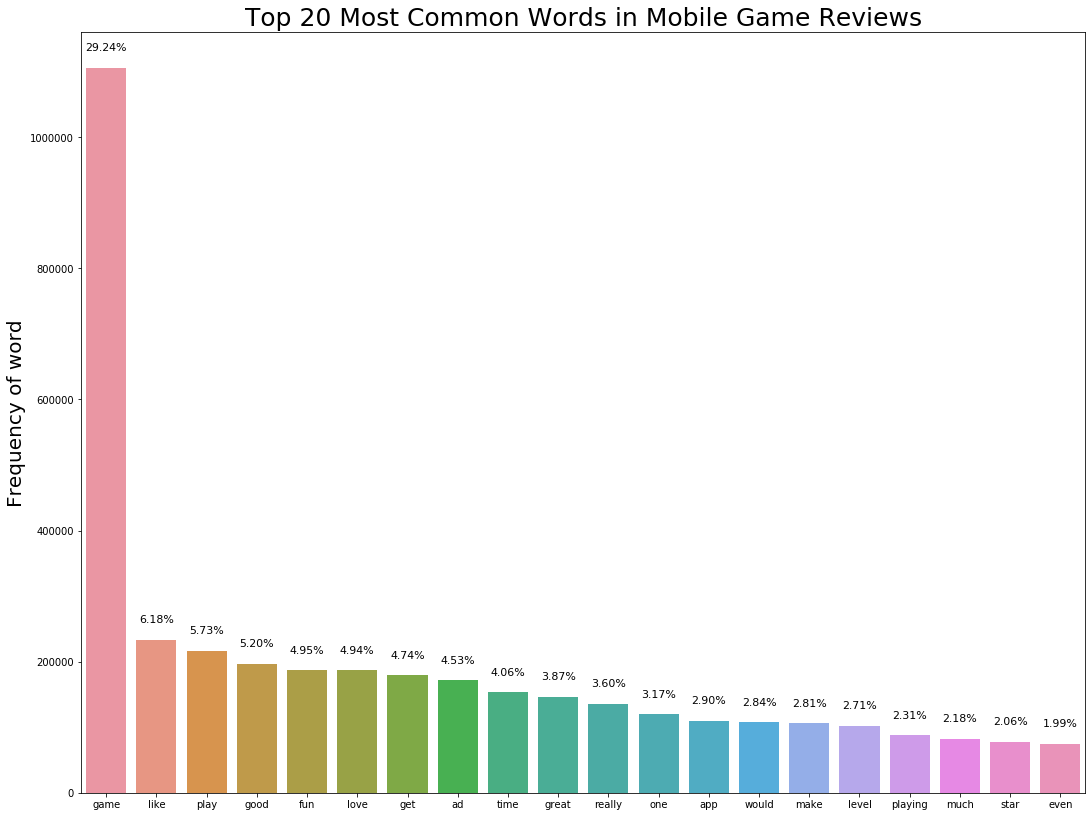

In [51]:
mostcommonwords20 = review_freqdist.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20]

xaxis20 = [val[0] for val in mostcommonwords20]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in Mobile Game Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Word Frequency in 1 Rating Reviews

In [52]:
uselesswords = ['game', 'play', 'really', 'get', 'would']
processedreviewrating1[:] = [x for x in processedreviewrating1 if x not in uselesswords]

In [53]:
review1_freqdist = FreqDist(processedreviewrating1)
review1_freqdist.most_common(20)

[('ad', 66607),
 ('time', 40962),
 ('like', 29535),
 ('app', 29447),
 ('even', 28418),
 ('money', 27062),
 ('level', 25021),
 ('one', 21893),
 ('every', 20310),
 ('many', 19186),
 ('make', 18418),
 ('good', 16983),
 ('playing', 16938),
 ('star', 16589),
 ('fix', 15009),
 ('give', 14771),
 ('want', 14501),
 ('update', 14366),
 ('fun', 14201),
 ('way', 13833)]

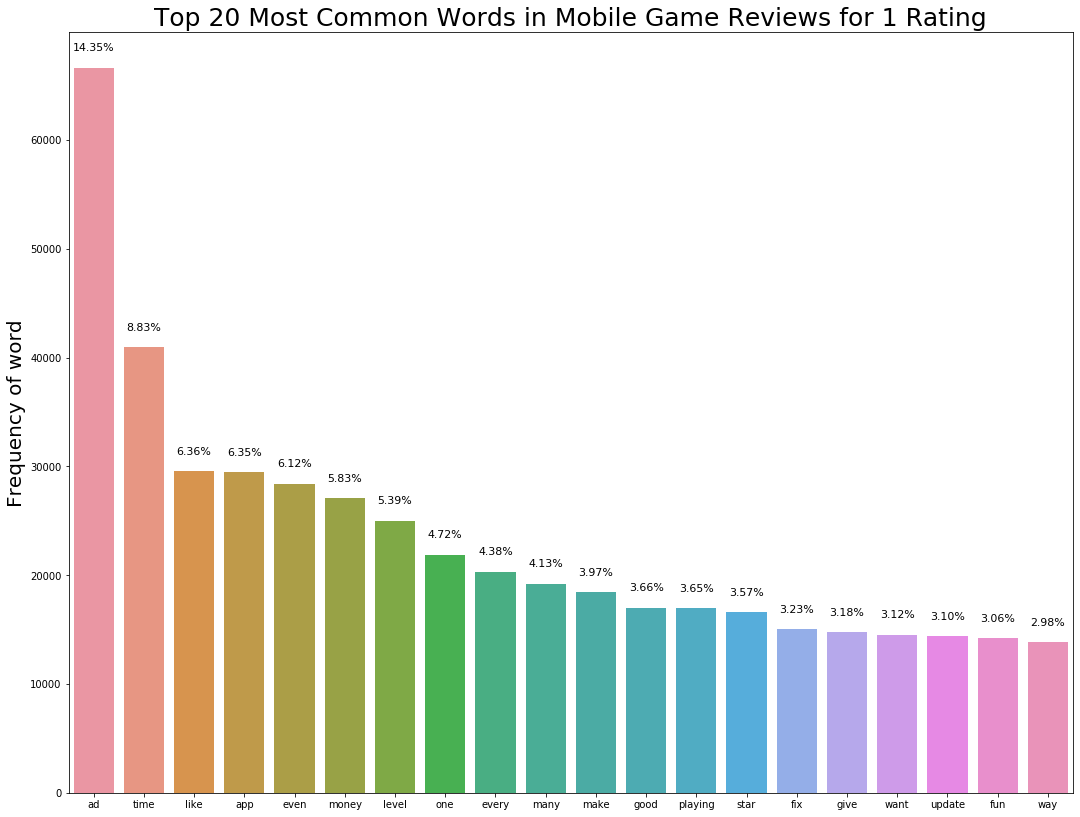

In [54]:
mostcommonwords201 = review1_freqdist.most_common(20)

yaxis201 = [val[1] for val in mostcommonwords201]

xaxis201 = [val[0] for val in mostcommonwords201]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201, yaxis201)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Word Frequency in 2 Rating Reviews

In [55]:
processedreviewrating2[:] = [x for x in processedreviewrating2 if x not in uselesswords]

In [56]:
review2_freqdist = FreqDist(processedreviewrating2)
review2_freqdist.most_common(20)

[('ad', 26280),
 ('like', 16571),
 ('time', 16333),
 ('level', 13654),
 ('good', 12079),
 ('fun', 11941),
 ('one', 9533),
 ('even', 9406),
 ('make', 9396),
 ('many', 9107),
 ('app', 9057),
 ('money', 8658),
 ('every', 8467),
 ('playing', 8007),
 ('way', 7576),
 ('star', 7367),
 ('fix', 7173),
 ('need', 6977),
 ("'m", 6684),
 ('much', 6677)]

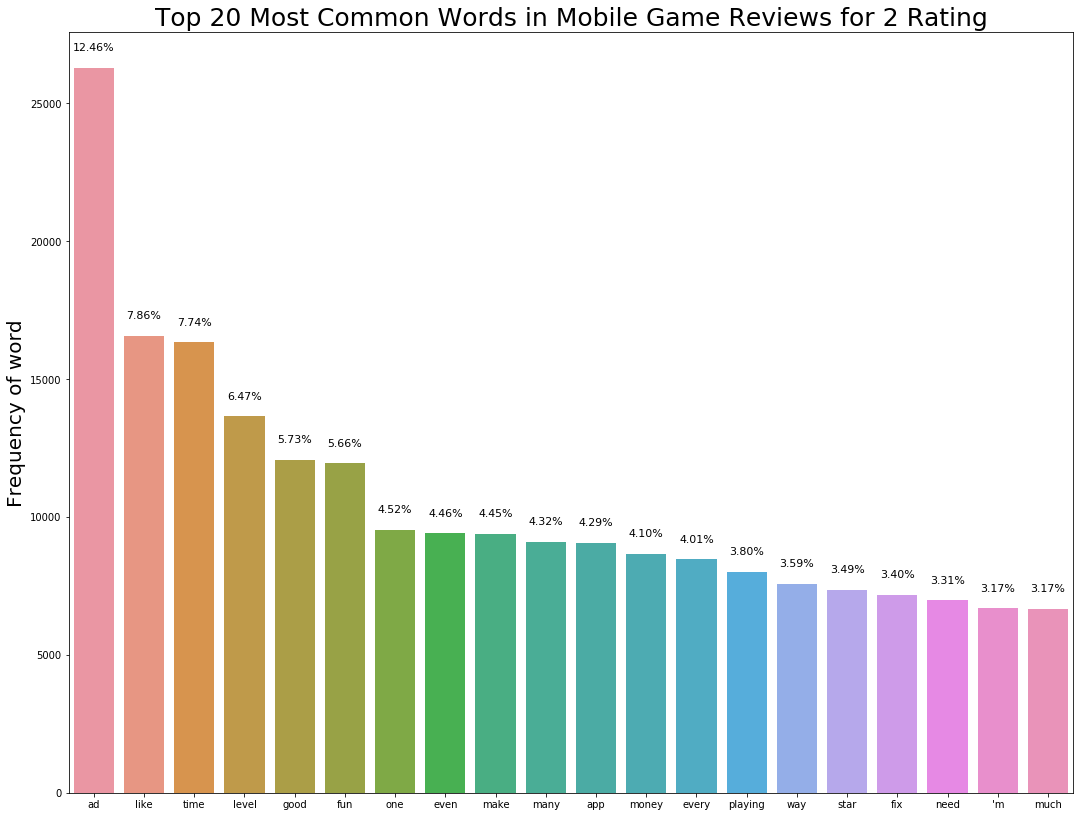

In [57]:
mostcommonwords202 = review2_freqdist.most_common(20)

yaxis202 = [val[1] for val in mostcommonwords202]

xaxis202 = [val[0] for val in mostcommonwords202]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202, yaxis202)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 2 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Word Frequency in 3 Rating Reviews

In [58]:
processedreviewrating3[:] = [x for x in processedreviewrating3 if x not in uselesswords]

In [59]:
review3_freqdist = FreqDist(processedreviewrating3)
review3_freqdist.most_common(20)

[('like', 27532),
 ('ad', 23964),
 ('good', 23893),
 ('time', 19691),
 ('fun', 18367),
 ('level', 16060),
 ('make', 13616),
 ('one', 13194),
 ('star', 12906),
 ('please', 11625),
 ('need', 11553),
 ('great', 11451),
 ('love', 10803),
 ('also', 10547),
 ('app', 10466),
 ('many', 10210),
 ('playing', 10126),
 ('fix', 10098),
 ('even', 9194),
 ('way', 9126)]

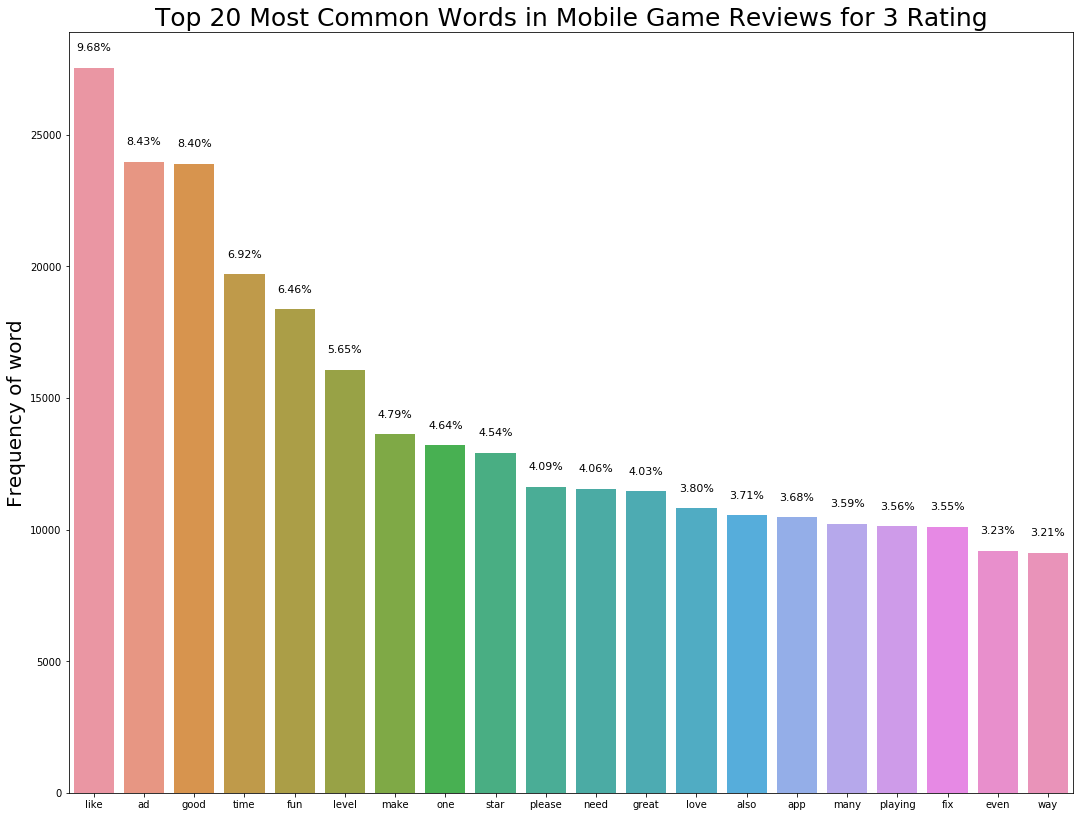

In [60]:
mostcommonwords203 = review3_freqdist.most_common(20)

yaxis203 = [val[1] for val in mostcommonwords203]

xaxis203 = [val[0] for val in mostcommonwords203]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203, yaxis203)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Word Frequency in 4 Rating Reviews

In [61]:
processedreviewrating4[:] = [x for x in processedreviewrating4 if x not in uselesswords]

In [62]:
review4_freqdist = FreqDist(processedreviewrating4)
review4_freqdist.most_common(20)

[('like', 45708),
 ('good', 43265),
 ('fun', 33869),
 ('great', 28634),
 ('love', 26818),
 ('time', 23976),
 ('ad', 22364),
 ('one', 20692),
 ('star', 20251),
 ('make', 19335),
 ('level', 16893),
 ('thing', 15472),
 ('please', 15377),
 ('add', 14884),
 ('also', 14313),
 ('app', 14206),
 ('need', 14161),
 ('could', 13114),
 ('nice', 12585),
 ('playing', 12525)]

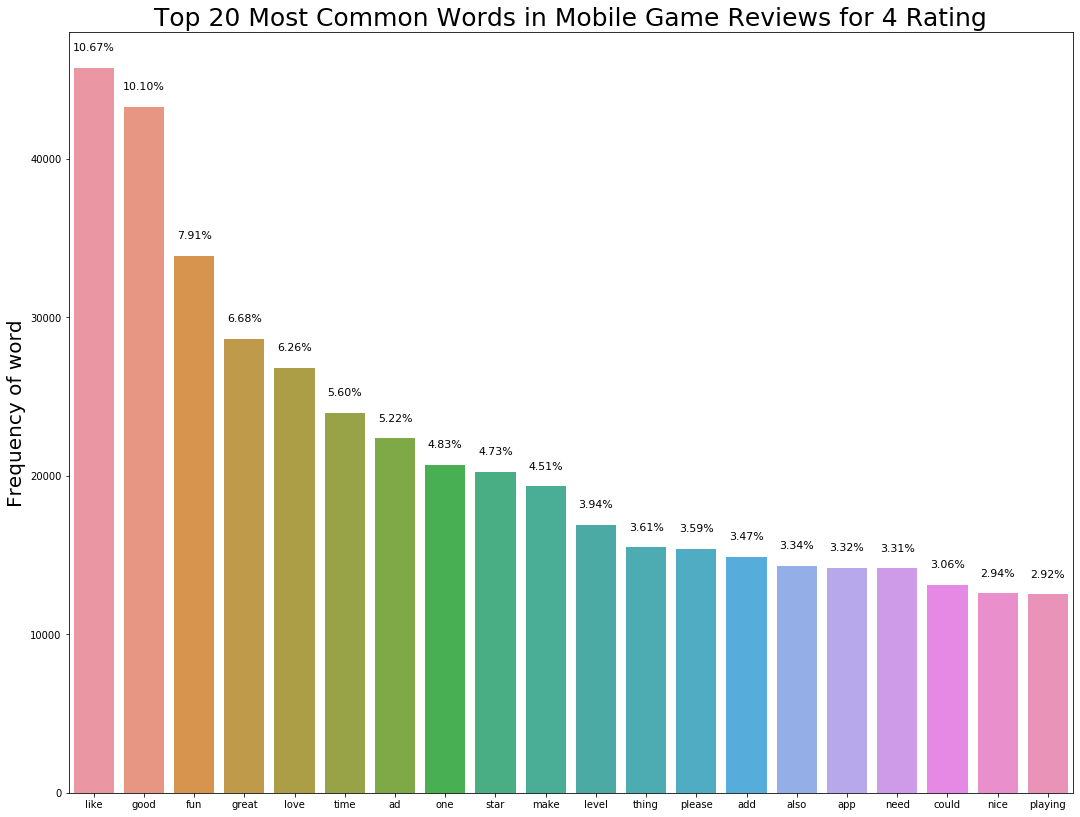

In [63]:
mostcommonwords204 = review4_freqdist.most_common(20)

yaxis204 = [val[1] for val in mostcommonwords204]

xaxis204 = [val[0] for val in mostcommonwords204]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204, yaxis204)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 4 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Word Frequency in 5 Rating Reviews

In [64]:
processedreviewrating5[:] = [x for x in processedreviewrating5 if x not in uselesswords]

In [65]:
review5_freqdist = FreqDist(processedreviewrating5)
review5_freqdist.most_common(20)

[('love', 137354),
 ('like', 114478),
 ('fun', 108814),
 ('good', 100229),
 ('great', 93286),
 ('one', 54477),
 ('best', 53465),
 ('time', 52571),
 ('app', 46358),
 ('make', 45403),
 ('much', 42850),
 ('playing', 39884),
 ('amazing', 39548),
 ('graphic', 35613),
 ('nice', 34818),
 ('ad', 32159),
 ('level', 30898),
 ('also', 30858),
 ('awesome', 30803),
 ('lot', 29761)]

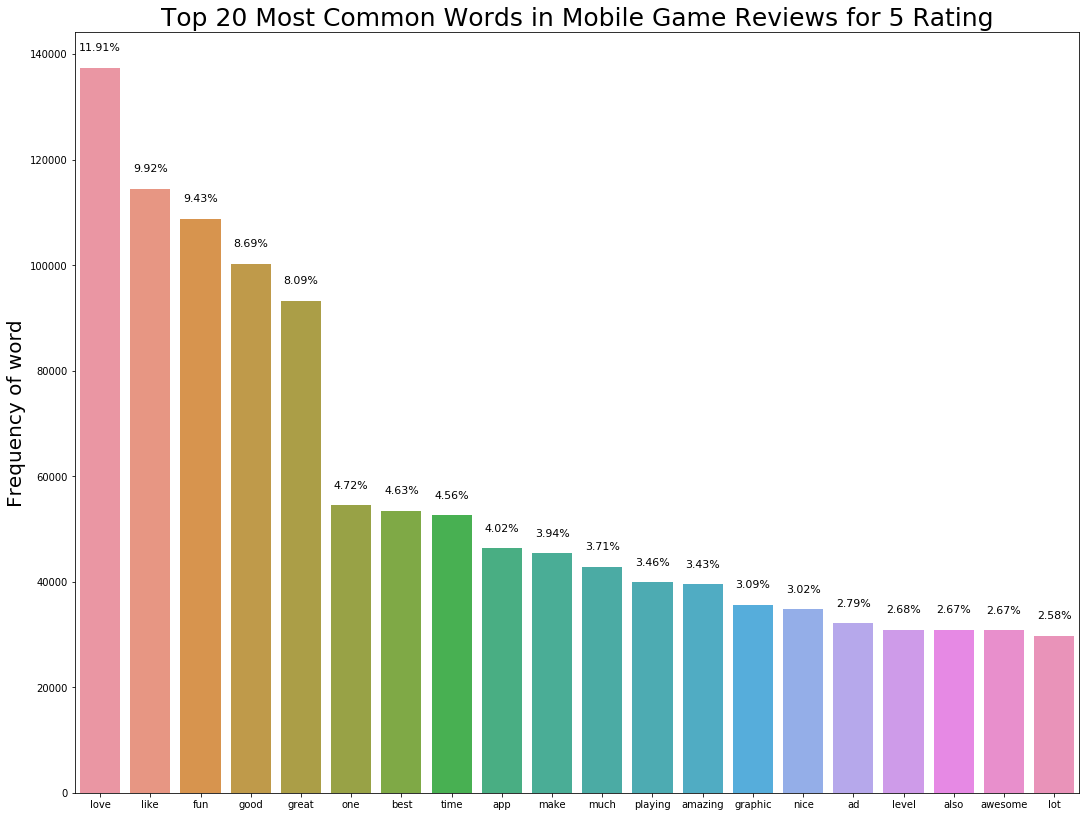

In [66]:
mostcommonwords205 = review5_freqdist.most_common(20)

yaxis205 = [val[1] for val in mostcommonwords205]

xaxis205 = [val[0] for val in mostcommonwords205]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205, yaxis205)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bi-grams/Tri-grams

In [67]:
# One without removing any common words to see common n-grams.

def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab


# One with removing common words to see if any more notable n-grams show up.

def n_gram(df_col, n=None):

    vect = CountVectorizer(ngram_range = (n,n), stop_words = stopwords_list, min_df = 10)

    vect_fit = vect.fit_transform(df_col.values.astype('U'))

    word_list = vect.get_feature_names()

    count_list = vect_fit.toarray().sum(axis=0)

    count_dict = dict(zip(word_list, count_list))

    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [68]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

stopwords_list += uselesswords

In [69]:
dftotalreview = dfreview['content']
dftotalreview

0          Great game! First, the bad. There are plenty o...
1          It's a really amazing start for a game but the...
2          A wonderful game to test how strong your bond ...
3          It's an extremely fun game, it's only setback ...
4          It's a really fun game, especially if you're t...
                                 ...                        
1041122                      Love this app.   Very helpful !
1041123                                       Excellent app.
1041124    Still doesn't find the highest scoring words 9...
1041125    Which is the best dictionary for English's uk ...
1041126    Fun game, but for a paid app it'd be better wi...
Name: content, Length: 1040901, dtype: object

In [70]:
bigramall = n_gramall(dftotalreview.sample(50000), n=2)
bigramall[:20]

[('love game', 3161),
 ('good game', 2395),
 ('great game', 2276),
 ('like game', 1479),
 ('fun game', 1281),
 ('play game', 1232),
 ('game play', 1141),
 ('many ads', 1078),
 ('game good', 966),
 ('playing game', 878),
 ('please fix', 877),
 ('game fun', 863),
 ('game ever', 847),
 ('best game', 808),
 ('game really', 803),
 ('game like', 782),
 ('nice game', 763),
 ('game much', 716),
 ('game great', 680),
 ('really like', 670)]

In [71]:
trigramall = n_gramall(dftotalreview.sample(50000), n=3)
trigramall[:20]

[('best game ever', 329),
 ('really like game', 276),
 ('game ever played', 248),
 ('love game much', 220),
 ('keep good work', 208),
 ('really good game', 202),
 ('way many ads', 182),
 ('really fun game', 157),
 ('like game much', 149),
 ('game really fun', 143),
 ('really love game', 130),
 ('game many ads', 112),
 ('game really good', 107),
 ('worst game ever', 107),
 ('really enjoy game', 101),
 ('one best games', 99),
 ('fun game play', 97),
 ('ads ads ads', 94),
 ('would give stars', 92),
 ('absolutely love game', 89)]

In [72]:
bigram = n_gram(dftotalreview.sample(50000), n=2)
bigram[:20]

[('many ads', 1076),
 ('please fix', 912),
 ('every time', 612),
 ('give stars', 471),
 ('one best', 426),
 ('waste time', 421),
 ('love much', 420),
 ('best ever', 375),
 ('ever played', 371),
 ('please make', 349),
 ('like much', 336),
 ('please add', 319),
 ('much fun', 316),
 ('way many', 302),
 ('love app', 294),
 ('pretty good', 291),
 ('spend money', 289),
 ('games like', 288),
 ('long time', 288),
 ('one thing', 287)]

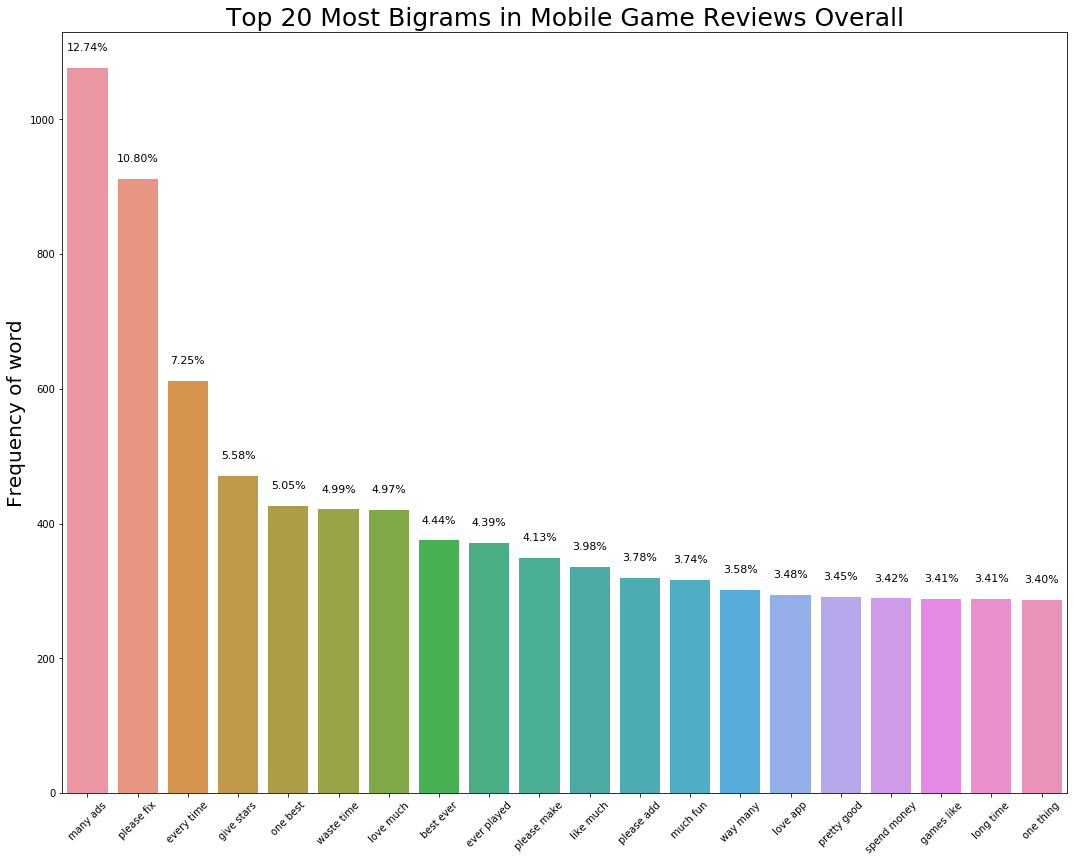

In [73]:
mostcommonwords20bigram = bigram[:20]

yaxis20bigram = [val[1] for val in mostcommonwords20bigram]

xaxis20biram = [val[0] for val in mostcommonwords20bigram]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biram, yaxis20bigram)
plt.title('Top 20 Most Bigrams in Mobile Game Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigram))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [74]:
trigram = n_gram(dftotalreview.sample(50000), n=3)
trigram[:20]

[('way many ads', 208),
 ('keep good work', 188),
 ('please please please', 144),
 ('best ever played', 92),
 ('one best games', 90),
 ('way pass time', 88),
 ('ads ads ads', 61),
 ('give five stars', 59),
 ('games ever played', 58),
 ('great time killer', 56),
 ('every time try', 53),
 ('please fix problem', 53),
 ('takes long time', 50),
 ('every single time', 49),
 ('love love love', 49),
 ('worth every penny', 49),
 ('want money back', 45),
 ('since last update', 43),
 ('30 second ad', 41),
 ('best games ever', 41)]

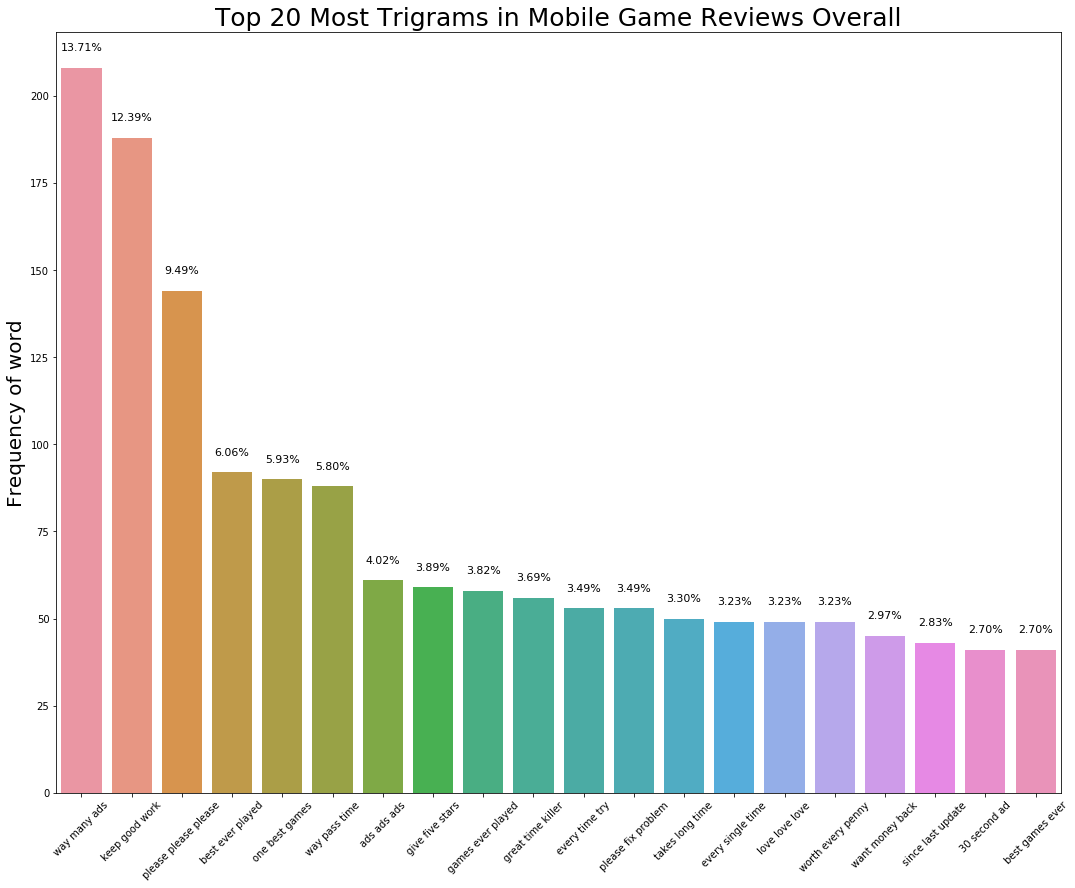

In [75]:
mostcommonwords20trigram = trigram[:20]

yaxis20trigram = [val[1] for val in mostcommonwords20trigram]

xaxis20triram = [val[0] for val in mostcommonwords20trigram]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20triram, yaxis20trigram)
plt.title('Top 20 Most Trigrams in Mobile Game Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20trigram))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams for Ratings

### Rating 1

In [76]:
bigram1 = n_gram(rating1['content'].sample(50000), n=2)
bigram1[:20]

[('many ads', 2223),
 ('waste time', 1722),
 ('every time', 1326),
 ('please fix', 1284),
 ('way many', 719),
 ('one star', 671),
 ('ads every', 646),
 ('spend money', 599),
 ('worst ever', 584),
 ('watch ad', 571),
 ('ads ads', 528),
 ('pay win', 490),
 ('ad every', 477),
 ('every single', 471),
 ('watch ads', 462),
 ('waste money', 457),
 ('every level', 453),
 ('give stars', 446),
 ('real money', 425),
 ('money back', 422)]

In [77]:
trigram1 = n_gram(rating1['content'].sample(50000), n=3)
trigram1[:20]

[('way many ads', 515),
 ('ads ads ads', 224),
 ('want money back', 186),
 ('30 second ad', 153),
 ('dont waste time', 151),
 ('worst ever played', 145),
 ('waste time money', 142),
 ('time watching ads', 137),
 ('ads every level', 124),
 ('every time try', 122),
 ('give one star', 116),
 ('ad every level', 108),
 ('every single time', 106),
 ('could give stars', 105),
 ('give zero stars', 105),
 ('spend time watching', 99),
 ('wish could give', 96),
 ('watching ads playing', 95),
 ('30 second ads', 89),
 ('many ads every', 82)]

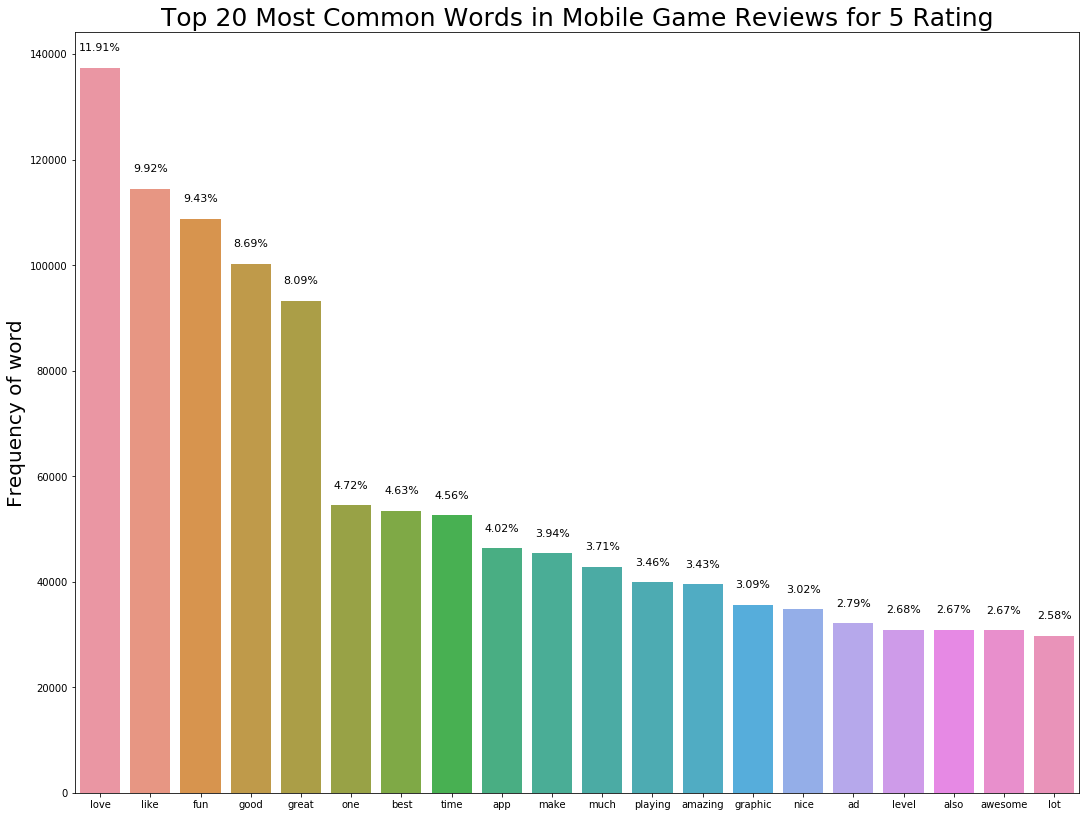

In [78]:
mostcommonwords205 = review5_freqdist.most_common(20)

yaxis205 = [val[1] for val in mostcommonwords205]

xaxis205 = [val[0] for val in mostcommonwords205]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205, yaxis205)
plt.title('Top 20 Most Common Words in Mobile Game Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

## Rating 2

In [79]:
bigram2 = n_gram(rating2['content'].sample(50000), n=2)
bigram2[:20]

[('many ads', 2571),
 ('please fix', 1813),
 ('every time', 1330),
 ('way many', 1014),
 ('watch ad', 694),
 ('ads every', 620),
 ('give stars', 615),
 ('spend money', 569),
 ('pay win', 519),
 ('watch ads', 508),
 ('real money', 505),
 ('every level', 502),
 ('ad every', 491),
 ('even though', 491),
 ('every single', 474),
 ('waste time', 470),
 ('watching ads', 408),
 ('ads ads', 376),
 ('two stars', 374),
 ('new update', 369)]

In [80]:
trigram2 = n_gram(rating2['content'].sample(50000), n=3)
trigram2[:20]

[('way many ads', 700),
 ('every single time', 126),
 ('time watching ads', 123),
 ('30 second ad', 116),
 ('every time try', 107),
 ('ads ads ads', 106),
 ('ads every level', 105),
 ('please fix problem', 102),
 ('ad every level', 94),
 ('30 second ads', 89),
 ('spend real money', 86),
 ('fun way many', 84),
 ('since last update', 81),
 ('every single level', 77),
 ('without spending money', 76),
 ('fun many ads', 75),
 ('spend time watching', 73),
 ('ads every single', 72),
 ('many ads every', 72),
 ('please fix issue', 71)]

## Rating 3

In [81]:
bigram3 = n_gram(rating3['content'].sample(50000), n=2)
bigram3[:20]

[('please fix', 2011),
 ('many ads', 1726),
 ('every time', 1002),
 ('give stars', 939),
 ('way many', 613),
 ('pretty good', 538),
 ('please make', 411),
 ('even though', 402),
 ('watch ad', 397),
 ('please add', 393),
 ('long time', 389),
 ('three stars', 387),
 ('feel like', 373),
 ('spend money', 370),
 ('real money', 363),
 ('pay win', 359),
 ('ads every', 340),
 ('go back', 320),
 ('one thing', 320),
 ('new update', 315)]

In [82]:
trigram3 = n_gram(rating3['content'].sample(50000), n=3)
trigram3[:20]

[('way many ads', 341),
 ('please fix problem', 122),
 ('takes long time', 102),
 ('good many ads', 101),
 ('give five stars', 94),
 ('every time try', 93),
 ('every single time', 92),
 ('gave three stars', 83),
 ('since last update', 83),
 ('fun many ads', 82),
 ('please fix bug', 77),
 ('give three stars', 73),
 ('please fix issue', 64),
 ('got new phone', 59),
 ('many ads every', 57),
 ('fun way many', 54),
 ('way many adds', 54),
 ('ad free version', 53),
 ('spend real money', 51),
 ('many ads like', 50)]

# Rating 4

In [83]:
bigram4 = n_gram(rating4['content'].sample(50000), n=2)
bigram4[:20]

[('please fix', 1268),
 ('many ads', 1063),
 ('give stars', 922),
 ('pretty good', 868),
 ('one thing', 601),
 ('please add', 593),
 ('every time', 556),
 ('please make', 471),
 ('wish could', 429),
 ('gave stars', 425),
 ('one problem', 397),
 ('four stars', 396),
 ('give star', 388),
 ('pretty fun', 385),
 ('overall good', 373),
 ('feel like', 365),
 ('good graphics', 362),
 ('little bit', 360),
 ('long time', 345),
 ('great app', 330)]

In [84]:
trigram4 = n_gram(rating4['content'].sample(50000), n=3)
trigram4[:20]

[('keep good work', 196),
 ('give five stars', 131),
 ('way many ads', 131),
 ('gave four stars', 128),
 ('way pass time', 103),
 ('reason gave stars', 87),
 ('please fix problem', 85),
 ('takes long time', 84),
 ('great time killer', 79),
 ('give four stars', 77),
 ('please please please', 75),
 ('good many ads', 74),
 ('reason give stars', 73),
 ('good time killer', 71),
 ('please fix bug', 65),
 ('give five star', 63),
 ('one best games', 63),
 ('one thing like', 61),
 ('please fix issue', 57),
 ('fun many ads', 55)]

## Rating 5

In [85]:
bigram5 = n_gram(rating5['content'].sample(50000), n=2)
bigram5[:20]

[('one best', 782),
 ('best ever', 720),
 ('love much', 634),
 ('ever played', 584),
 ('like much', 547),
 ('much fun', 511),
 ('love app', 424),
 ('good work', 413),
 ('games like', 404),
 ('please make', 375),
 ('please add', 366),
 ('keep good', 364),
 ('highly recommend', 355),
 ('love love', 349),
 ('great graphics', 348),
 ('good graphics', 338),
 ('great app', 330),
 ('super fun', 321),
 ('well done', 315),
 ('lots fun', 311)]

In [86]:
trigram5 = n_gram(rating5['content'].sample(50000), n=3)
trigram5[:20]

[('keep good work', 324),
 ('best ever played', 191),
 ('one best games', 147),
 ('please please please', 120),
 ('way pass time', 106),
 ('love love love', 104),
 ('games ever played', 96),
 ('great time killer', 96),
 ('keep great work', 81),
 ('worth every penny', 79),
 ('best games ever', 65),
 ('one favorite games', 61),
 ('fun fun fun', 59),
 ('make games like', 59),
 ('well worth money', 57),
 ('give five stars', 56),
 ('great way pass', 55),
 ('love much fun', 55),
 ('mega ramp car', 42),
 ('great pass time', 41)]